In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from imblearn.metrics import sensitivity_specificity_support as sss
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix as CM

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Conv3D, GlobalAveragePooling3D,  MaxPooling3D, LeakyReLU, BatchNormalization, Dropout, Flatten, Activation, Reshape,  Conv3DTranspose, UpSampling3D
from tensorflow.keras.regularizers import l2, l1, l1_l2

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ma-u

In [2]:
# cretae the binary input 
def data_filter(data, label, exclu):
    idx = np.where(label!= exclu)[0]
    #print(len(idx))
    data_new = data[idx]
    label_new = label[idx]
    #print(data_new.shape)
    print(np.unique(label_new, return_counts=True))
    return data_new, label_new

# onehot encode labels for binary classifications
def onehot_bi(y):
    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    y = y.reshape(len(y), 1)
    y_encoded = onehot_encoder.fit_transform(y)
    return y_encoded

# onehot encode labels for 3-way classifications
def onehot_tri(y):
    from keras.utils import to_categorical
    return to_categorical(y)

# view the distribution of class labels of the input data
def showpercentage(array):
    pcn = array[1][0]/np.sum(array[1])
    pmci = array[1][1]/np.sum(array[1])
    pad = array[1][2]/np.sum(array[1])
    print(str(pad) + " percent of the data has AD label")
    print(str(pcn) + " percent of the data has CN label")
    print(str(pmci) + " percent of the data has MCI label")
# visualizatio of model traning and model performance 

# visualize the training and validation performance
def plot_history(data_list, label_list, title, ylabel, name):

    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title, pad = 10, fontsize='large')
    plt.xlabel('Epochs', labelpad=10)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()
#%%

# model evaluation
    
# evaluate model performance - binary classifications
def evaluate_binary(X_test, y_test, model, name):
    
    test_y_prob = model.predict(X_test)
    print(test_y_prob)
    test_y_pred = np.argmax(test_y_prob, axis = 1)
    test_y_true = np.argmax(y_test, axis = 1) 
    # accuracy
    
    loss, acc = model.evaluate(X_test, y_test)
    # AUC
    pos_prob = test_y_prob[:,1]
    auc_score = roc_auc_score(test_y_true, pos_prob)
    # precision, recall, specificity, and f1_score
    p = precision_score(test_y_true, test_y_pred)
    r = recall_score(test_y_true, test_y_pred)
    f1 = f1_score(test_y_true, test_y_pred)
#     sen, spe, _ = sss(test_y_true, test_y_pred, average="binary")
    print(test_y_true, test_y_pred)
    # print results
    print("Test accuracy:", acc)
    print("Test AUC is: ", auc_score)
    print("Test confusion matrix: \n", CM(test_y_true, test_y_pred))
    print("Precision: ", p)
    print("Recall: ", r)
#     print("Specificity: ", spe)
    print("f1_score: ", f1)

    # plot and save roc curve
    pos_prob = test_y_prob[:,1]
    fpr, tpr, thresholds = roc_curve(test_y_true, pos_prob)
    ns_probs = [0 for _ in range(len(test_y_prob))]
    ns_fpr, ns_tpr, _ = roc_curve(test_y_true, ns_probs)
    plt.axis([0,1,0,1]) 
    plt.plot(fpr,tpr, marker = '.', color = 'darkorange', label = 'Model AUC (area = {:.2f})'.format(auc_score)) 
    plt.plot(ns_fpr, ns_tpr, color = 'royalblue', linestyle='--')
    plt.legend()
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()
    
# evaluate model performance - 3 way classifiations
def evaluate_3way(X_test, y_test, model):
    test_y_prob = model.predict(X_test)
    test_y_pred = np.argmax(test_y_prob, axis = 1)
    test_y_true = np.argmax(y_test, axis = 1) 
    print(test_y_prob)
    # accuracy
    loss, acc = model.evaluate(X_test, y_test)
    # precision, recall, specificity, and f1_score
    p = precision_score(test_y_true, test_y_pred, average="macro")
    r = recall_score(test_y_true, test_y_pred, average="macro")
    f1 = f1_score(test_y_true, test_y_pred, average="macro")
#     sen,spe,_ = sss(test_y_true, test_y_pred, average="macro")
    print(test_y_true, test_y_pred)
    print("Test accuracy:", acc)
    print("Test confusion matrix: \n", CM(test_y_true, test_y_pred))
    print("Precision: ", p)
    print("Recall: ", r)
#     print("Specificity: ", spe)
    print("f1_score: ", f1)

In [3]:
import logging
import numpy as np
import tensorflow as tf

In [4]:
"""  Load in the input - original data """

Xtr = np.load("preprocess/input/random_split/train_data.npy", allow_pickle = True)
ytr = np.load("preprocess/input/random_split/train_label.npy", allow_pickle = True)
print(Xtr.shape)
print(ytr.shape)

Xts = np.load("preprocess/input/random_split/test_data.npy", allow_pickle = True)
yts = np.load("preprocess/input/random_split/test_label.npy", allow_pickle = True)
print(Xts.shape)
print(yts.shape)

Xval = np.load("preprocess/input/random_split/val_data.npy", allow_pickle = True)
yval = np.load("preprocess/input/random_split/val_label.npy", allow_pickle = True)
print(Xval.shape)
print(yval.shape)

print("Train:")
showpercentage(np.unique(ytr, return_counts=True))
print()
print("Validation:")
showpercentage(np.unique(yval, return_counts=True))
print()
print("Test")
showpercentage(np.unique(yts, return_counts=True))

(356, 64, 64, 64)
(356,)
(86, 64, 64, 64)
(86,)
(90, 64, 64, 64)
(90,)
Train:
0.2893258426966292 percent of the data has AD label
0.41853932584269665 percent of the data has CN label
0.29213483146067415 percent of the data has MCI label

Validation:
0.28888888888888886 percent of the data has AD label
0.4222222222222222 percent of the data has CN label
0.28888888888888886 percent of the data has MCI label

Test
0.29069767441860467 percent of the data has AD label
0.4186046511627907 percent of the data has CN label
0.29069767441860467 percent of the data has MCI label


In [5]:
def get_voxcnn( X_train, y_train, X_valid = None, y_valid = None, 
             final = False, out = 2,
             dr = 0.02, lr = 0.00001, 
             breg = l2(0.0001), areg = None, 
             n_epochs = 100, batch_size = 15 ):
  
    inputs = keras.Input((64, 64, 64, 1))

    x = Conv3D(32, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(inputs)

    x = Conv3D(32, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = Conv3D(32, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    x = Conv3D(64, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = Conv3D(64, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = Conv3D(128, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = Conv3D(128, kernel_size=(3,3,3),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = Conv3D(256, kernel_size=(2,2,2),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = Conv3D(256, kernel_size=(2,2,2),  kernel_initializer='he_uniform', padding="same",activation="relu", bias_regularizer=breg)(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = Dropout(dr)(x)
    x = Flatten()(x)
    x = Dense(512, bias_regularizer=breg,   kernel_initializer='he_uniform',activation="relu")(x)
    x = Dropout(dr)(x)
    x = Dense(256, bias_regularizer=breg,   kernel_initializer='he_uniform',activation="relu")(x)
    outputs  = Dense(out, activation='softmax', activity_regularizer=areg)(x)
    
    model = keras.Model(inputs,outputs , name="3dcnn")
    
    opt = Adam(lr = lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 

    cb = ReduceLROnPlateau(monitor = 'val_loss', 
                         factor = 0.5, patience = 5, 
                         verbose = 1, epsilon = 1e-4, mode = 'min')
    

    hist = model.fit(X_train, y_train,
                 batch_size = batch_size, 
                 epochs = n_epochs,
                 callbacks=[cb],
                 validation_data = (X_valid, y_valid), 
                 shuffle = True)
    
    return model, hist


In [6]:
# model=get_voxcnn()
# model.summary()

In [7]:
# create input for binary classification of NC vs. AD
Xtr_ncad, ytr_ncad = data_filter(Xtr, ytr, 1)
Xval_ncad, yval_ncad = data_filter(Xval, yval, 1)
Xts_ncad, yts_ncad = data_filter(Xts, yts, 1)

# reshape the input
X_train = Xtr_ncad.reshape(-1,64,64,64,1) 
X_test = Xts_ncad.reshape(-1,64,64,64,1) 
X_val = Xval_ncad.reshape(-1,64,64,64,1) 


# one hot encode the target labels 
y_train = onehot_bi(ytr_ncad)
y_test = onehot_bi(yts_ncad)
y_val = onehot_bi(yval_ncad)



# model training
model, hist = get_voxcnn(X_train, y_train, X_val, y_val, 
                       breg = l2(0.001), areg = l1(0.001))

(array([0, 2]), array([149, 103]))
(array([0, 2]), array([38, 26]))
(array([0, 2]), array([36, 25]))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 252 samples, validate on 64 samples
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

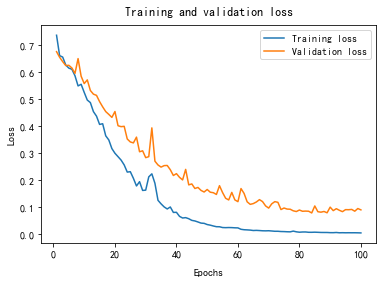

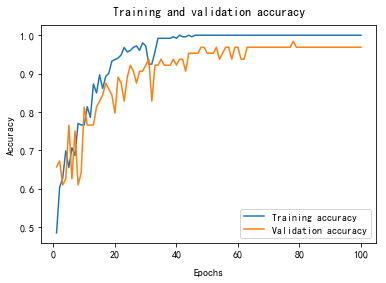

In [18]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_ncad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_ncad_acc')

[[9.99461472e-01 5.38566208e-04]
 [8.43587935e-01 1.56412065e-01]
 [9.89771783e-01 1.02281468e-02]
 [9.96130943e-01 3.86900455e-03]
 [9.18149948e-01 8.18500817e-02]
 [9.95064676e-01 4.93530743e-03]
 [8.57587397e-01 1.42412618e-01]
 [9.94884312e-01 5.11570694e-03]
 [9.85163510e-01 1.48365479e-02]
 [3.61286514e-02 9.63871360e-01]
 [9.97578442e-01 2.42156303e-03]
 [1.27802610e-01 8.72197390e-01]
 [8.93073375e-05 9.99910712e-01]
 [9.93308544e-01 6.69149822e-03]
 [1.88299328e-01 8.11700642e-01]
 [1.24678873e-01 8.75321150e-01]
 [1.04143703e-03 9.98958588e-01]
 [9.93229151e-01 6.77077286e-03]
 [9.99269426e-01 7.30591360e-04]
 [9.40923214e-01 5.90767898e-02]
 [1.59227028e-02 9.84077334e-01]
 [9.71721590e-01 2.82784253e-02]
 [9.95421231e-01 4.57878225e-03]
 [9.93283272e-01 6.71672868e-03]
 [9.92019951e-01 7.98008963e-03]
 [9.87963319e-01 1.20366719e-02]
 [1.42732784e-01 8.57267201e-01]
 [9.25192773e-01 7.48073012e-02]
 [3.22962664e-02 9.67703760e-01]
 [3.85626704e-01 6.14373326e-01]
 [9.993189

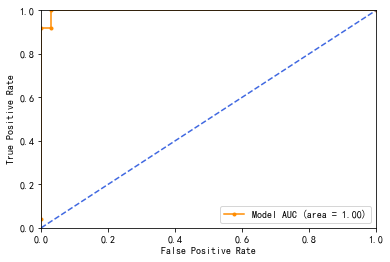

In [19]:
evaluate_binary(X_test, y_test, model, name = 'base_roc_ncad')

In [20]:
"""  Baseline NC vs. MCI """

# create input for binary classification of NC vs. MCI
Xtr_ncmci, ytr_ncmci = data_filter(Xtr, ytr, 2)
Xval_ncmci, yval_ncmci = data_filter(Xval, yval, 2)
Xts_ncmci, yts_ncmci = data_filter(Xts, yts, 2)

# reshape the input
X_train = Xtr_ncmci.reshape(-1,64,64,64,1) 
X_test = Xts_ncmci.reshape(-1,64,64,64,1) 
X_val = Xval_ncmci.reshape(-1,64,64,64,1) 

# one hot encode the target labels 
y_train = onehot_bi(ytr_ncmci)
y_test = onehot_bi(yts_ncmci)
y_val = onehot_bi(yval_ncmci)


# model training
model, hist = get_voxcnn(X_train, y_train, X_val, y_val, areg = l1(0.001))

(array([0, 1]), array([149, 104]))
(array([0, 1]), array([38, 26]))
(array([0, 1]), array([36, 25]))
Train on 253 samples, validate on 64 samples
Epoch 1/100
253/253 [==============================] - 9s 37ms/sample - loss: 0.8784 - acc: 0.4980 - val_loss: 0.6754 - val_acc: 0.5938
Epoch 2/100
253/253 [==============================] - 7s 27ms/sample - loss: 0.6717 - acc: 0.5652 - val_loss: 0.6687 - val_acc: 0.5938
Epoch 3/100
253/253 [==============================] - 7s 27ms/sample - loss: 0.6382 - acc: 0.6482 - val_loss: 0.6320 - val_acc: 0.6250
Epoch 4/100
253/253 [==============================] - 7s 27ms/sample - loss: 0.6130 - acc: 0.6759 - val_loss: 0.6352 - val_acc: 0.6250
Epoch 5/100
253/253 [==============================] - 7s 27ms/sample - loss: 0.6030 - acc: 0.6601 - val_loss: 0.6176 - val_acc: 0.6562
Epoch 6/100
253/253 [==============================] - 7s 27ms/sample - loss: 0.5709 - acc: 0.7036 - val_loss: 0.6043 - val_acc: 0.6406
Epoch 7/100
253/253 [=================

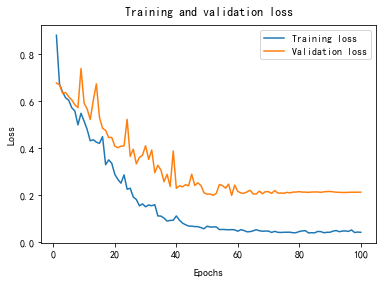

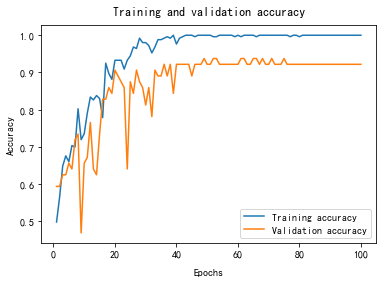

In [21]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_ncmci_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_ncmci_acc')

[[0.99469477 0.0053052 ]
 [0.11327658 0.8867234 ]
 [0.7390511  0.26094884]
 [0.9620141  0.03798587]
 [0.12215209 0.87784785]
 [0.5932829  0.4067171 ]
 [0.07848457 0.9215154 ]
 [0.10675833 0.8932417 ]
 [0.01628061 0.9837194 ]
 [0.06177283 0.9382271 ]
 [0.73529094 0.26470903]
 [0.12041375 0.8795863 ]
 [0.9381395  0.06186054]
 [0.9095868  0.09041322]
 [0.03965639 0.9603436 ]
 [0.9740844  0.02591564]
 [0.42242277 0.57757723]
 [0.8883901  0.11160981]
 [0.05033596 0.949664  ]
 [0.11125927 0.8887408 ]
 [0.08409235 0.9159077 ]
 [0.19279906 0.8072009 ]
 [0.97196543 0.02803455]
 [0.09294681 0.9070532 ]
 [0.9959352  0.00406474]
 [0.974767   0.02523298]
 [0.04939766 0.9506023 ]
 [0.9188822  0.08111781]
 [0.10414554 0.8958544 ]
 [0.9481505  0.05184945]
 [0.8922479  0.10775203]
 [0.96845865 0.03154135]
 [0.8837241  0.1162759 ]
 [0.9534026  0.04659741]
 [0.04976592 0.9502341 ]
 [0.07393836 0.92606163]
 [0.9740157  0.02598435]
 [0.935774   0.06422592]
 [0.04119316 0.9588069 ]
 [0.03711076 0.9628892 ]


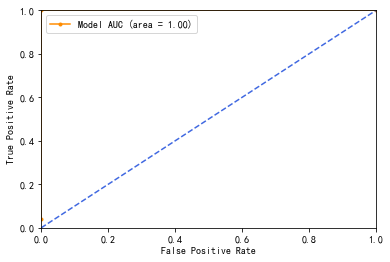

In [22]:
evaluate_binary(X_test, y_test, model, name = 'base_roc_ncmci')

In [24]:
"""  Baseline MCI vs. AD """

# create input for binary classification of MCI vs. AD
Xtr_admci, ytr_admci = data_filter(Xtr, ytr, 0)
Xval_admci, yval_admci = data_filter(Xval, yval, 0)
Xts_admci, yts_admci = data_filter(Xts, yts, 0)

# reshape the input
X_train = Xtr_admci.reshape(-1,64,64,64,1) 
X_test = Xts_admci.reshape(-1,64,64,64,1) 
X_val = Xval_admci.reshape(-1,64,64,64,1) 

# one hot encode the target labels 
y_train = onehot_bi(ytr_admci)
y_test = onehot_bi(yts_admci)
y_val = onehot_bi(yval_admci)


# model training
model, hist = get_voxcnn(X_train, y_train, X_val, y_val, dr = 0.03)


(array([1, 2]), array([104, 103]))
(array([1, 2]), array([26, 26]))
(array([1, 2]), array([25, 25]))
Train on 207 samples, validate on 52 samples
Epoch 1/100
207/207 [==============================] - 7s 33ms/sample - loss: 0.7896 - acc: 0.5411 - val_loss: 0.7608 - val_acc: 0.5000
Epoch 2/100
207/207 [==============================] - 6s 27ms/sample - loss: 0.6847 - acc: 0.5411 - val_loss: 0.6717 - val_acc: 0.6154
Epoch 3/100
207/207 [==============================] - 6s 27ms/sample - loss: 0.6458 - acc: 0.6473 - val_loss: 0.6637 - val_acc: 0.6154
Epoch 4/100
207/207 [==============================] - 6s 27ms/sample - loss: 0.6210 - acc: 0.6812 - val_loss: 0.6623 - val_acc: 0.5962
Epoch 5/100
207/207 [==============================] - 6s 27ms/sample - loss: 0.6363 - acc: 0.6522 - val_loss: 0.7628 - val_acc: 0.5000
Epoch 6/100
207/207 [==============================] - 6s 27ms/sample - loss: 0.6322 - acc: 0.6087 - val_loss: 0.6356 - val_acc: 0.6923
Epoch 7/100
207/207 [=================

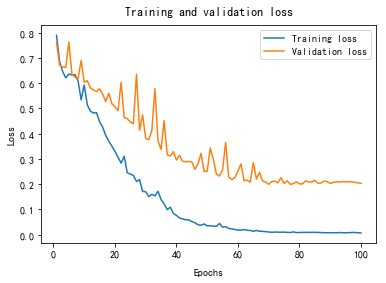

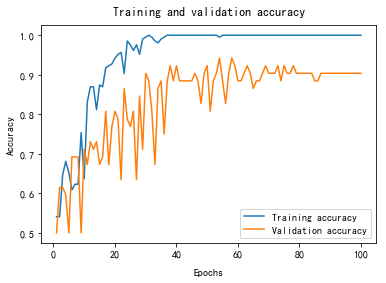

In [25]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_mciad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_mciad_acc')

[[0.9925258  0.00747416]
 [0.78757435 0.21242566]
 [0.9867725  0.01322756]
 [0.9714308  0.02856926]
 [0.9955519  0.00444809]
 [0.9885527  0.01144727]
 [0.9096253  0.09037474]
 [0.8966584  0.10334154]
 [0.9130747  0.08692531]
 [0.05822683 0.9417732 ]
 [0.9865302  0.01346984]
 [0.20485257 0.7951474 ]
 [0.08225807 0.9177419 ]
 [0.97607064 0.02392939]
 [0.03905964 0.9609404 ]
 [0.9662997  0.03370029]
 [0.9978382  0.00216187]
 [0.42364365 0.5763564 ]
 [0.89749813 0.10250185]
 [0.97785836 0.02214159]
 [0.0029666  0.99703336]
 [0.9971042  0.00289572]
 [0.01276375 0.9872363 ]
 [0.9009546  0.09904546]
 [0.8927645  0.10723556]
 [0.01375803 0.98624194]
 [0.92416584 0.07583416]
 [0.02720464 0.97279537]
 [0.1137571  0.88624287]
 [0.98304707 0.01695294]
 [0.9850745  0.01492544]
 [0.03021878 0.9697813 ]
 [0.9772107  0.02278931]
 [0.01010445 0.9898956 ]
 [0.6732179  0.32678208]
 [0.0892224  0.9107776 ]
 [0.21569729 0.78430265]
 [0.05225093 0.947749  ]
 [0.97346526 0.02653479]
 [0.0057522  0.9942478 ]


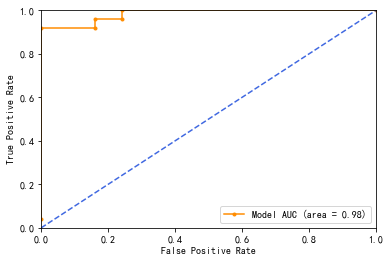

In [26]:
evaluate_binary(X_test, y_test, model, name = 'base_roc_mciad')

In [8]:
"""   Baseline NC vs. MCI vs. AD """

# reshape the input for 3-way classification of NC vs. AD
X_train = Xtr.reshape(-1,64,64,64,1) 
X_test = Xts.reshape(-1,64,64,64,1) 
X_val = Xval.reshape(-1,64,64,64,1) 

# one hot encode the target labels 
y_train = onehot_tri(ytr)
y_test = onehot_tri(yts)
y_val = onehot_tri(yval)


# model training
model, hist = get_voxcnn(X_train, y_train, X_val, y_val, 
                       breg = l2(0.001), out = 3)


Using TensorFlow backend.


Train on 356 samples, validate on 90 samples
Epoch 1/100
356/356 [==============================] - 16s 46ms/sample - loss: 1.1684 - acc: 0.3708 - val_loss: 1.0855 - val_acc: 0.4222
Epoch 2/100
356/356 [==============================] - 10s 27ms/sample - loss: 1.0657 - acc: 0.4270 - val_loss: 1.0803 - val_acc: 0.4222
Epoch 3/100
356/356 [==============================] - 10s 27ms/sample - loss: 1.0330 - acc: 0.4382 - val_loss: 1.0882 - val_acc: 0.4333
Epoch 4/100
356/356 [==============================] - 10s 27ms/sample - loss: 1.0337 - acc: 0.4551 - val_loss: 1.0382 - val_acc: 0.5444
Epoch 5/100
356/356 [==============================] - 10s 27ms/sample - loss: 0.9919 - acc: 0.5421 - val_loss: 1.1295 - val_acc: 0.4222
Epoch 6/100
356/356 [==============================] - 10s 27ms/sample - loss: 1.0396 - acc: 0.4382 - val_loss: 1.1410 - val_acc: 0.4222
Epoch 7/100
356/356 [==============================] - 10s 27ms/sample - loss: 0.9774 - acc: 0.5309 - val_loss: 1.0078 - val_acc: 0.5

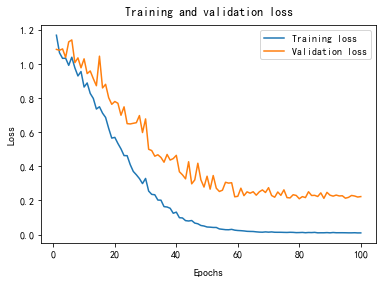

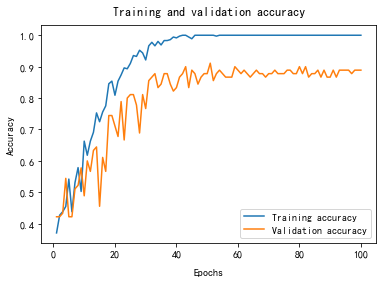

In [9]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_ncmciad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_ncmciad_acc')

In [10]:
evaluate_3way(X_test, y_test, model)

[[9.96054649e-01 2.07859557e-03 1.86674227e-03]
 [1.32412761e-02 9.86629367e-01 1.29362626e-04]
 [9.28011954e-01 4.82707545e-02 2.37174053e-02]
 [9.83383119e-01 8.65331665e-03 7.96356425e-03]
 [3.34701426e-02 9.12611067e-01 5.39187901e-02]
 [8.25336754e-01 1.65735587e-01 8.92759673e-03]
 [4.49558673e-03 9.93286908e-01 2.21745996e-03]
 [1.57425031e-02 9.77809012e-01 6.44844212e-03]
 [1.56960031e-03 9.95675504e-01 2.75491807e-03]
 [5.67717943e-03 9.88597214e-01 5.72560029e-03]
 [4.99309599e-01 3.35455120e-01 1.65235311e-01]
 [9.43585038e-01 4.64883745e-02 9.92658455e-03]
 [7.85931230e-01 1.56822875e-01 5.72458990e-02]
 [2.19507758e-02 8.14796507e-01 1.63252681e-01]
 [9.93921161e-01 3.79921636e-03 2.27970025e-03]
 [9.68815923e-01 3.99236428e-03 2.71917339e-02]
 [3.94586101e-02 1.32686654e-02 9.47272778e-01]
 [3.41708376e-03 9.92750525e-01 3.83237959e-03]
 [9.90174055e-01 1.52222323e-03 8.30368884e-03]
 [1.36859491e-01 9.43173766e-02 7.68823147e-01]
 [2.46368727e-04 1.06954493e-01 8.927991